In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from xgboost import plot_importance
import warnings
warnings.filterwarnings('ignore')
sns.set()

## Read Data

In [2]:
data_file = Path.cwd().parent / 'data' / 'kaggle' / 'base-gender-10-percent-dataset-unique-CVIDs.csv'

df = pd.read_csv(data_file, index_col='Match_ID')
df = df[df.columns[1:]]
df.columns = (
    'cv_id',
    'experience', 
    'french_level',
    'status',
    'cv_received',
    'cv_validated',
    'cv_approved',
    'gender',
    'match_status'
)

df.index.names = ['match_id']

df['cv_received'] = pd.to_datetime(df.cv_received)
df['cv_validated'] = pd.to_datetime(df.cv_validated)
df['cv_approved'] = pd.to_datetime(df.cv_approved)

df.sample(1)

,cv_id,experience,french_level,status,cv_received,cv_validated,cv_approved,gender,match_status
match_id,,,,,,,,,
514,353,[8+],A2,Matched,NaT,NaT,NaT,M,0.0


## EDA

In [3]:
status_go_match = [
    'A01 - Offer Preparation Started',
    'A02 - Offer Sent to Candidate',
    'A03 - Offer accepted',
    'A03 - Offer declined',
    'A03 - Process Cancelled',
    'A04 - Hiring Request Started',
    'A04a – Hiring Started / Collecting signatures',
    'A04b – Hiring Started / Contract signed',
    'A05 - Onboarding',
    'A06 - Offboarding',
    'B01 - Subcontracting Started',
    'B02 - Subcontracting Signed',
    'D01 – Resignation',
    'T01- Terminated',
    'Candidate validated'
]
df_go = df[df['status'].isin(status_go_match)]
no_go_pct = (1 - df_go.shape[0] / df.shape[0]) * 100
print("Input data has only {}/{} ({}%) accepted candidates.".format(
    df_go.shape[0],
    df.shape[0],
    round(df_go.shape[0] / df.shape[0] * 100, 2)
))
print("Since the data is so skewed, we will not use accuracy as a performance measure")

Input data has only 347/2255 (15.39%) accepted candidates.
Since the data is so skewed, we will not use accuracy as a performance measure


## Feature Engineering
### Add Computed features

In [4]:
df['response_time'] = (df['cv_validated'] - df['cv_received']).dt.days
df['decision_time'] = (df['cv_approved'] - df['cv_validated']).dt.days

In [5]:
df.sample(1)

,cv_id,experience,french_level,status,cv_received,cv_validated,cv_approved,gender,match_status,response_time,decision_time
match_id,,,,,,,,,,,
10107,574,NaN,NaN,CV refused,2016-11-15,2016-11-15,NaT,F,0.0,0.0,NaN


### Add Mapped Status 
Boolean _Go_ -> 1 or _No Go_ -> 0

In [6]:
status_map = {
    'Rejected': 0,
    'CV refused': 0,
    'A02 - Offer Sent to Candidate': 1,
    'Candidate refused': 0,
    'A03 - Offer declined': 1,
    'D01 – Resignation': 1,
    'A05 - Onboarding': 1,
    'Candidate dropped out': 0,
    'CV dropped out': 0,
    'T01- Terminated': 1,
    'A03 - Process Cancelled': 1,
    'Dropped out': 0,
    'Approved': 0,
    'CV sent to France': 0,
    'Matched': 0,
    'Candidate validated': 1,
    'A01 - Offer Preparation Started': 1,
    'A04b – Hiring Started / Contract signed': 1,
    'A03 - Offer accepted': 1,
    'CV approved': 0,
    'A04 - Hiring Request Started': 1,
    'Sent to Client': 0
}
df['status_mapped'] = df.status.map(status_map).astype(int)

In [7]:
df.sample(1)

,cv_id,experience,french_level,status,cv_received,cv_validated,cv_approved,gender,match_status,response_time,decision_time,status_mapped
match_id,,,,,,,,,,,,
11445,7181,[8+],A1,Dropped out,2017-10-31,2018-04-03,NaT,M,1.0,154.0,NaN,0


### Remove Outliers

In [10]:
rt_outliers = df.index[df['response_time'] < 0]
dt_outliers = df.index[df['decision_time'] < 0]

df.loc[rt_outliers, 'response_time'] = df.loc[rt_outliers, 'response_time'].fillna(df.response_time.mean())
df.loc[dt_outliers, 'decision_time'] = df.loc[dt_outliers, 'decision_time'].fillna(df.decision_time.mean())

### Augmenting

In [11]:
df['french_level'] = df['french_level'].fillna('0')
df = df[df['experience'].notnull()]
df.skew() # <- TODO address high skew

cv_id            0.589300
match_status    -1.202949
response_time    5.161424
decision_time    2.773463
status_mapped    0.187861
dtype: float64

In [12]:
ct = pd.crosstab(df['response_time'], df['status_mapped'])
ct.columns = ['Positive Candidate', 'Negative Candidate']
ct.head()

,Positive Candidate,Negative Candidate
response_time,,
0.0,102,221
1.0,37,42
2.0,9,10
3.0,5,9
4.0,6,5


### Reduce skew

<AxesSubplot:title={'center':'After Transformation'}, xlabel='response_time', ylabel='Density'>

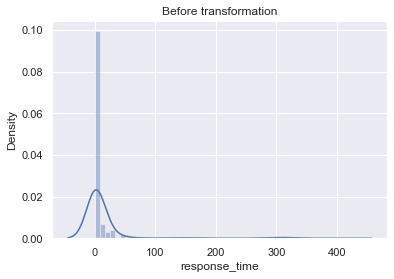

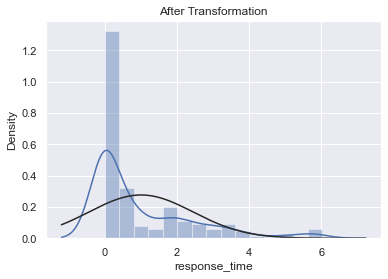

In [13]:
from scipy.stats import norm, skew

plt.title('Before transformation')
rt = df.response_time.dropna() + 1
sns.distplot(df.response_time)

plt.figure()
plt.title('After Transformation')
sns.distplot(rt.apply(np.log), fit=norm)

<AxesSubplot:title={'center':'After Transformation'}, xlabel='decision_time', ylabel='Density'>

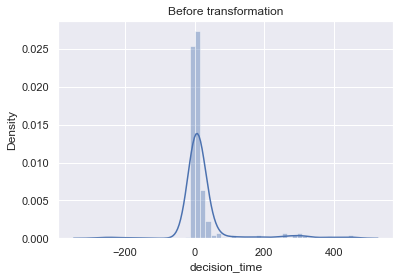

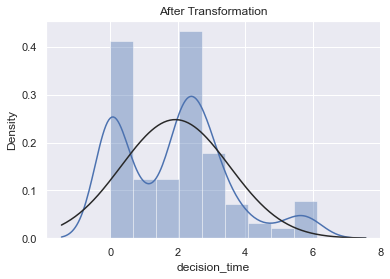

In [14]:
from scipy.stats import norm, skew
from scipy.special import boxcox1p

plt.title('Before transformation')
rt = df.decision_time.dropna() + 1
sns.distplot(df.decision_time)

plt.figure()
plt.title('After Transformation')
sns.distplot(rt.apply(np.log), fit=norm)

In [15]:
# df = df[['status_mapped', 'french_level', 'experience', 'response_time', 'decision_time']]

In [16]:
df.head()

,cv_id,experience,french_level,status,cv_received,cv_validated,cv_approved,gender,match_status,response_time,decision_time,status_mapped
match_id,,,,,,,,,,,,
10551,1025,[0-1],B1,A03 - Offer declined,2017-03-15,2017-03-17,2017-04-05,M,1.0,2.0,19.0,1
10234,1045,[0-1],B1,Rejected,NaT,NaT,NaT,F,1.0,NaN,NaN,0
10745,1045,[0-1],B1,CV refused,2017-05-05,2017-05-05,NaT,M,1.0,0.0,NaN,0
10840,1045,[0-1],B1,CV refused,2017-05-23,2017-05-23,NaT,M,1.0,0.0,NaN,0
10845,1045,[0-1],B1,A03 - Offer declined,2017-05-23,2017-05-23,2017-06-30,F,1.0,0.0,38.0,1


### Label encoding
Helps us predict on certain categories of data

In [17]:
# Split decision times into groups of 20 day periods
decision_time_splits = np.ceil(df['decision_time'].max() / 20).astype(int)
decision_map = pd.concat(
    pd.Series(str(i + 1), index=range(i * 20, 20 + i * 20)) 
    for i in range(decision_time_splits)
)

df['response_time'] = df['response_time'].map(decision_map)
df['decision_time'] = df['decision_time'].map(decision_map)

# Replace decision and reponse times by their log values
df['decision_time'] = df['decision_time'].astype(float).dropna().apply(np.log)
df['response_time'] = df['response_time'].astype(float).dropna().apply(np.log)

# Rename target/dependent variable
df.rename(index=str, columns={'status_mapped': 'y'}, inplace=True)

Encode (replace unique values by integers) experience and french level

In [18]:
le = LabelEncoder()

le.fit(df['experience'].unique())
df['experience'] = le.transform(df['experience'])

le.fit(df['french_level'].unique())
df['french_level'] = le.transform(df['french_level'])
df['french_level'].fillna('0', inplace=True)

le.fit(df['gender'].unique())
df['gender'] = le.transform(df['gender'])

Remove rows with null values

In [19]:
response_time_nulls = df.response_time[df.response_time.isnull()].index
decision_time_nulls = df.decision_time[df.decision_time.isnull()].index
french_level_nulls = df.french_level[df.french_level.isnull()].index

indices_to_drop = response_time_nulls.union(decision_time_nulls).union(french_level_nulls)
df.drop(indices_to_drop, inplace=True)

### Prepare for one hot encoding

In [20]:
experience_unique = df.experience.unique()
french_level_unique = df.french_level.unique()
gender_unique = df.gender.unique()

experience_unique, french_level_unique, gender_unique

(array([0, 3, 1, 2]), array([3, 1, 0, 6, 2, 4, 5, 7]), array([1, 0]))

In [21]:
experience_map = dict((e, int(bool(e > max(experience_unique) / 2))) for e in experience_unique)
french_level_map = dict((f, int(bool(f + 1 > max(french_level_unique) / 2))) for f in french_level_unique)

In [22]:
sorted(experience_map.items()), sorted(french_level_map.items())

([(0, 0), (1, 0), (2, 1), (3, 1)],
 [(0, 0), (1, 0), (2, 0), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)])

In [23]:
df['experience'] = df['experience'].map(experience_map)
df['french_level'] = df['french_level'].map(experience_map)

### One hot encoding

In [24]:
for column in ('french_level', 'experience', 'gender'):
    dummies = pd.get_dummies(df[column], prefix=f'_{column}')
    df = df.join(dummies, how='outer').drop([column], axis=1)

In [25]:
df.columns.to_list()

['cv_id',
 'status',
 'cv_received',
 'cv_validated',
 'cv_approved',
 'match_status',
 'response_time',
 'decision_time',
 'y',
 '_french_level_0.0',
 '_french_level_1.0',
 '_experience_0',
 '_experience_1',
 '_gender_0',
 '_gender_1']

In [26]:
df = df[[
    'y', 
    'response_time', 
    'decision_time', 
    '_french_level_0.0', 
    '_french_level_1.0',
    '_experience_0',
    '_experience_1',
    '_gender_0',
    '_gender_1'
]]

In [27]:
y = df['y']
X = df.drop(['y', '_experience_0', '_french_level_0.0', '_gender_0'], axis=1)

### Hold out & Cross validation

In [28]:
n_hold_out = 100
X, y = X[:-n_hold_out], y[:-n_hold_out]
X_cv, y_cv = X[:n_hold_out], y[:n_hold_out]

<AxesSubplot:>

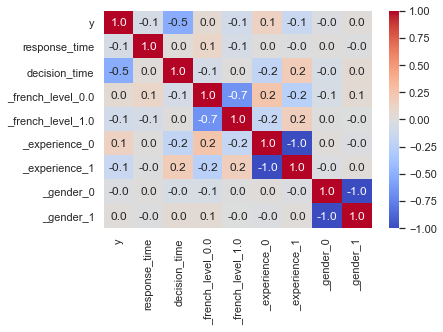

In [29]:
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.1f')

## Split, train and predict on test set

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = XGBClassifier()
model.fit(X_train, y_train)

[13:17:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
y_pred = model.predict(X_test)

In [32]:
from pprint import pprint
pprint(classification_report(y_test, y_pred, output_dict=True))

{'0': {'f1-score': 0.5263157894736842,
       'precision': 1.0,
       'recall': 0.35714285714285715,
       'support': 14},
 '1': {'f1-score': 0.9461077844311377,
       'precision': 0.8977272727272727,
       'recall': 1.0,
       'support': 79},
 'accuracy': 0.9032258064516129,
 'macro avg': {'f1-score': 0.736211786952411,
               'precision': 0.9488636363636364,
               'recall': 0.6785714285714286,
               'support': 93},
 'weighted avg': {'f1-score': 0.8829132905665749,
                  'precision': 0.9131231671554252,
                  'recall': 0.9032258064516129,
                  'support': 93}}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

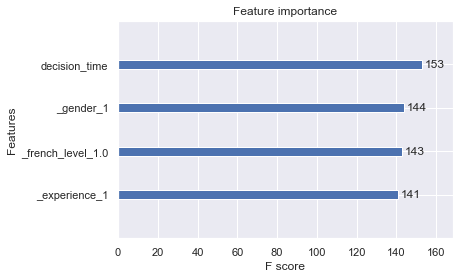

In [33]:
plot_importance(model)